# KMeans classification for climate on Earth from temperature and specific humidity CORDEX dataset

This notebook presents a brief method to classify the different climate on Earth in a monthly time frame. The two variables taken in account are temperature and specific humidity downloaded from ESGF data node. To keep it simple, we will only focus on climate variability during January.

## Import module and read data

The datasets are both on a monthly resolution, downloaded from ESGF data node and the simulation is from KNMI.

In [1]:
import xarray as xr
import sklearn as sk
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from IPython.core.debugger import set_trace
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from global_land_mask import globe

In [2]:
#PATH
path_data = '/Users/xavier/Projets/Climate/data/'
path_ta = path_data+'temperature/Africa/*.nc'
path_sh = path_data+'humidity/Africa/*.nc'
path_topo = path_data+'topography/GEBCO_2020.nc'

In [3]:
ta = xr.open_mfdataset(path_ta)
sh = xr.open_mfdataset(path_sh)

In [4]:
tas = ta['tas']
huss = sh['huss']


## Time synchronisation

The specific humidity dimension and temperature have different starting points. We need to select the time slice in the temperature that fits the specific humidity vector.

In [5]:
#Removing the last month in the temperature field
time_start = huss.time.values[0]
time_end = huss.time.values[-1]
tas = tas.sel(time=slice(time_start, time_end))

## Structuring the data for the model and ignoring ocean data points

On this step we shape the data for the model. We want each point to have 2 values: [temperature, specific humidity]

We also split the data monthly to compare the yearly evolution of each month. The idea would be to measure the climate change in each point from year to year. We consider a climate change in a point if the point changes from one cluster to another across a year.

To split the ocean data points and the land points we use globe module. 

In [6]:
#Standardization
def standardization(data):
    data_mean = data.mean()
    data_std = data.std()
    return (data-data_mean)/data_std

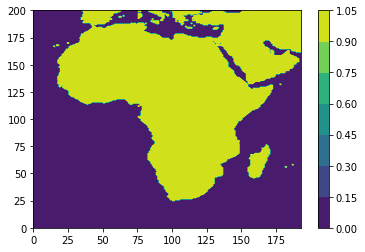

In [7]:
lon_grid, lat_grid = np.meshgrid(tas.rlon, tas.rlat)
globe_land_mask = globe.is_land(lat_grid, lon_grid)

plt.contourf(globe_land_mask)
plt.colorbar()

In [8]:
#Standardize the data
temp = standardization(tas)
huss_ = standardization(huss)

In [9]:
temp.values[0,:]

array([[-1.669773 , -1.6752369, -1.6786106, ..., -1.7435625, -1.7491518,
        -1.7549065],
       [-1.6211982, -1.6279255, -1.6330386, ..., -1.6963061, -1.702888 ,
        -1.7094297],
       [-1.568563 , -1.5764081, -1.5832608, ..., -1.6449392, -1.6511651,
        -1.658138 ],
       ...,
       [-1.0158738, -1.0288771, -1.0395344, ..., -3.9742258, -4.005872 ,
        -4.0068245],
       [-1.0306317, -1.042888 , -1.0530092, ..., -4.066227 , -4.065916 ,
        -4.0768695],
       [-1.0456603, -1.0562775, -1.0659473, ..., -4.0873213, -4.1562433,
        -4.2337623]], dtype=float32)

In [10]:
#We set a specific value for the ocean data point
#It means we will have only one cluster to represent the ocean climate
tas_land = temp.where(temp*globe_land_mask!=0, np.min(temp))
huss_land = huss_.where(huss_*globe_land_mask!=0, np.min(huss_))

In [11]:
temp_monthly = temp.groupby('time.month').groups
temp_stack = tas_land.stack(y=('rlat','rlon')).values
huss_stack = huss_land.stack(y=('rlat','rlon')).values

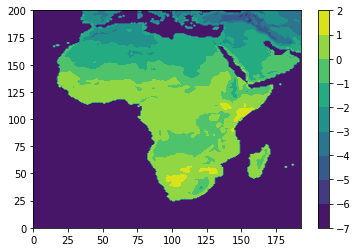

In [12]:
plt.figure()
plt.contourf(tas_land.values[0,:])
plt.colorbar()

In [13]:
data = {}
for i in [*temp_monthly]:
    print(i)
    data[i] = {}
    for t, value in enumerate(temp_monthly[i]):
        ti = temp_stack[value,:]
        hi = huss_stack[value,:]
        mat = np.zeros((len(ti),2))
        for u,_ in enumerate(ti):
            mat[u,:] = np.array([ti[u],hi[u]])
        data[i][t] = {'arr':mat,
                      'year':temp.time.dt.year.values[t]}


1
2
3
4
5
6
7
8
9
10
11
12


## Kmeans clustering  optimal selection with silhouette score

Since the purpose is not to realize a complete research project but just test an idea we will only focus on the month of January for the clustering. 
We couldn't find an optimal value for the number of cluster. From good sense, we will consider 8 different climates in our case. 
Note that the results will necessarily have a biais due to data from the ocean surface.



For n_clusters = 6 The average silhouette_score is : 0.7595769125531047
For n_clusters = 7 The average silhouette_score is : 0.7546317109145682
For n_clusters = 8 The average silhouette_score is : 0.7667678090819012
For n_clusters = 9 The average silhouette_score is : 0.7544136841257173
For n_clusters = 10 The average silhouette_score is : 0.7545037098240097
For n_clusters = 11 The average silhouette_score is : 0.7489627267644444
For n_clusters = 12 The average silhouette_score is : 0.7481966952305823
For n_clusters = 13 The average silhouette_score is : 0.7405734064191648
For n_clusters = 14 The average silhouette_score is : 0.7430277146395624


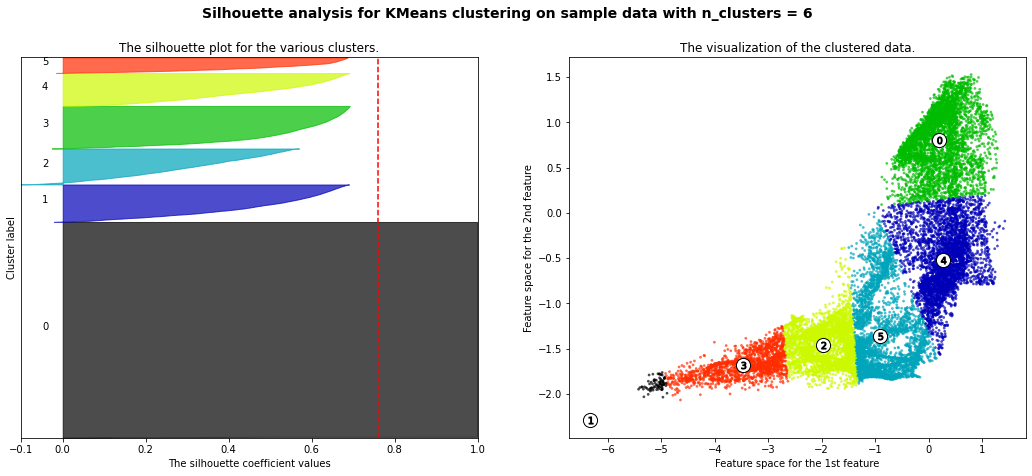

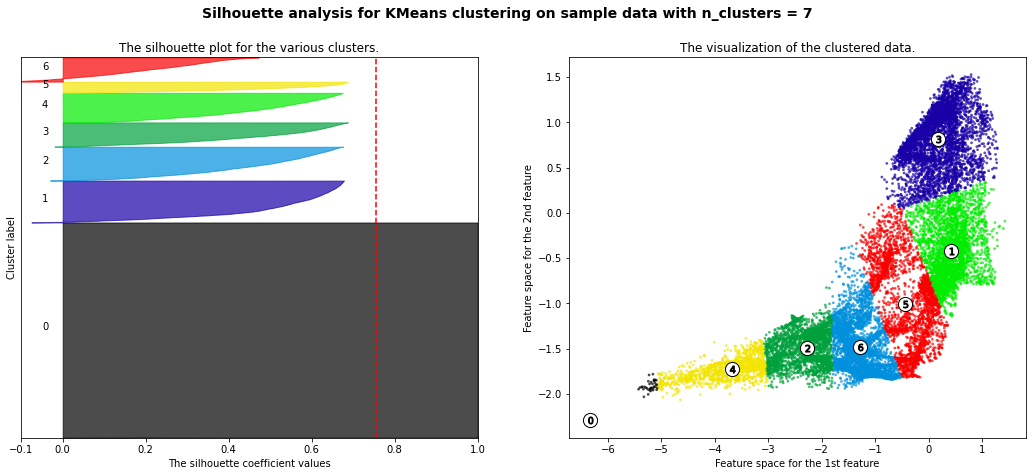

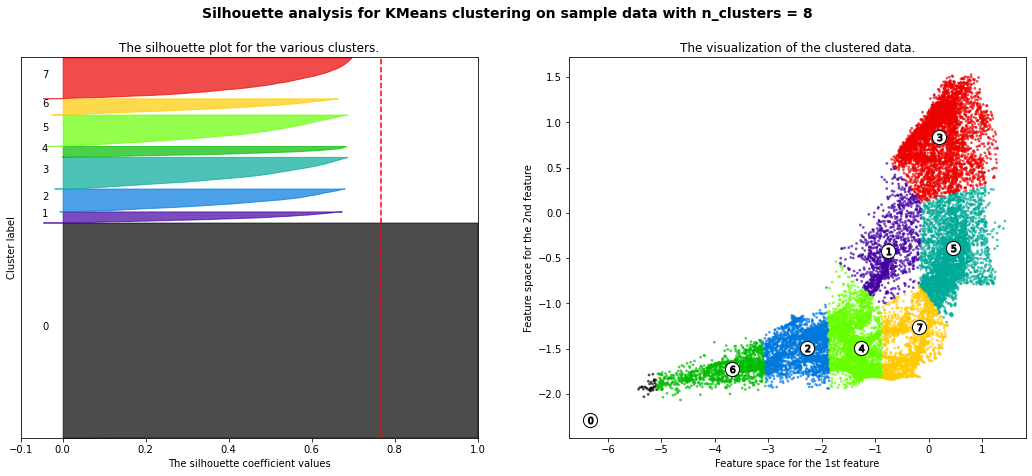

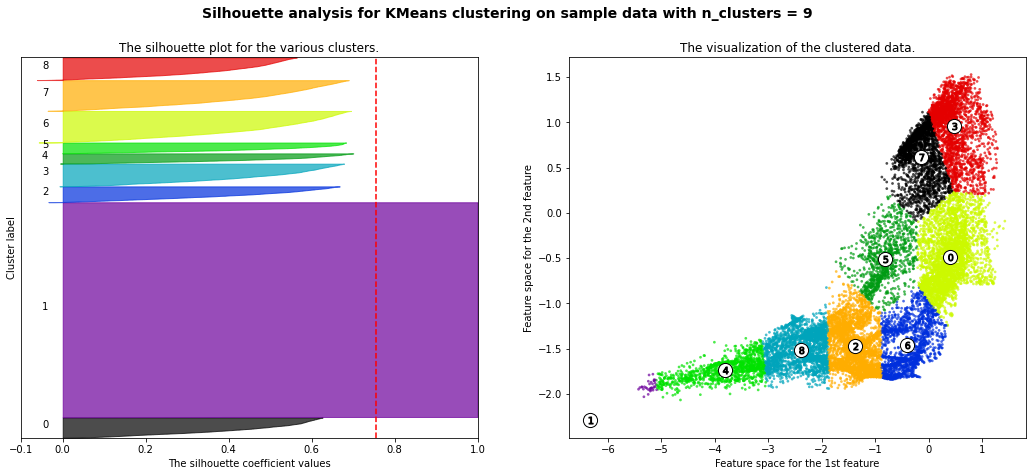

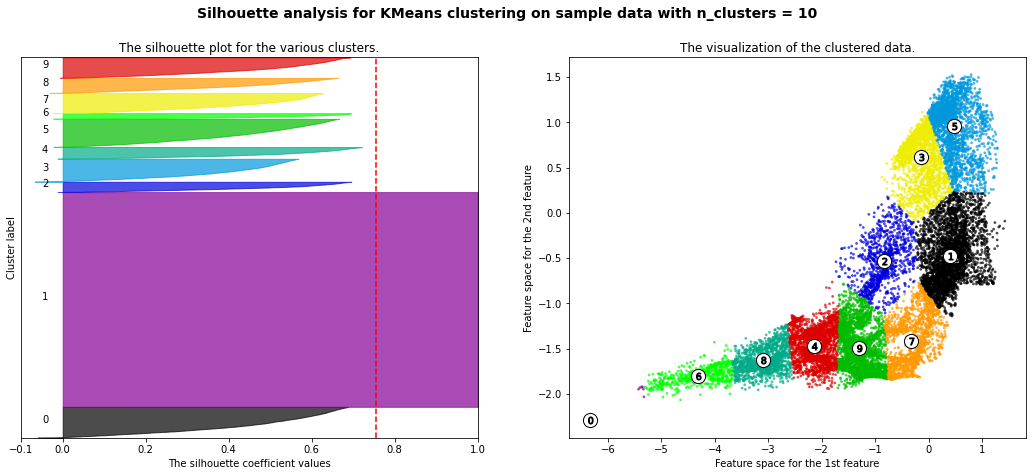

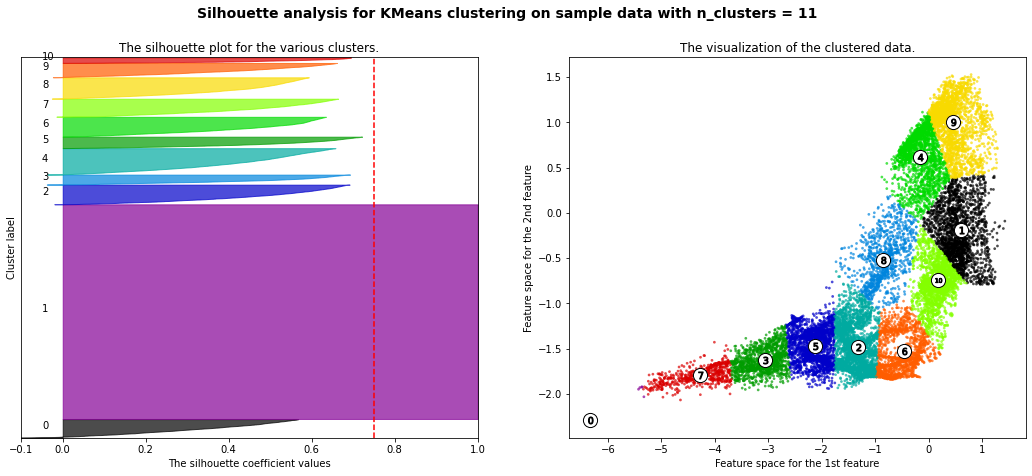

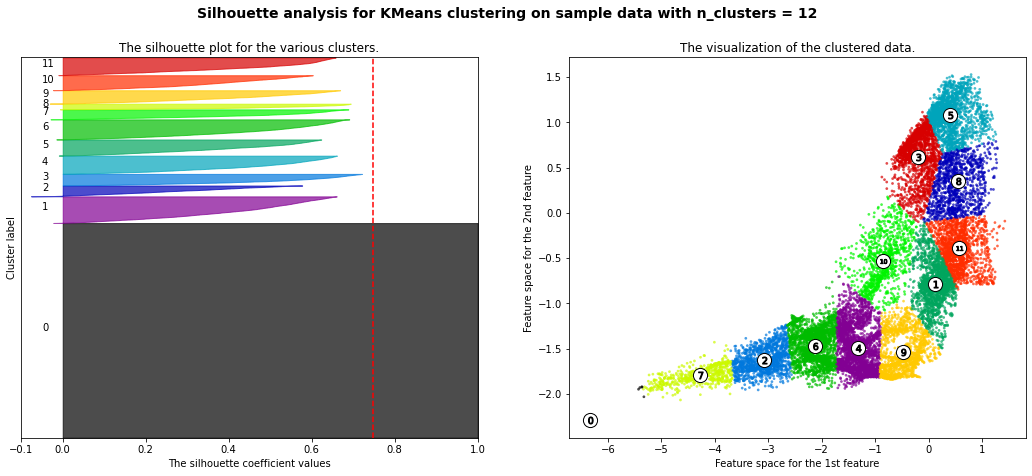

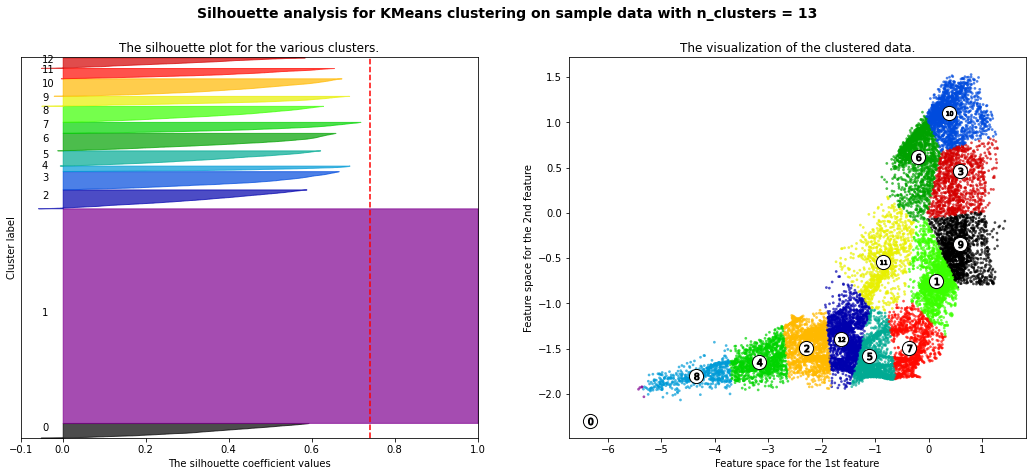

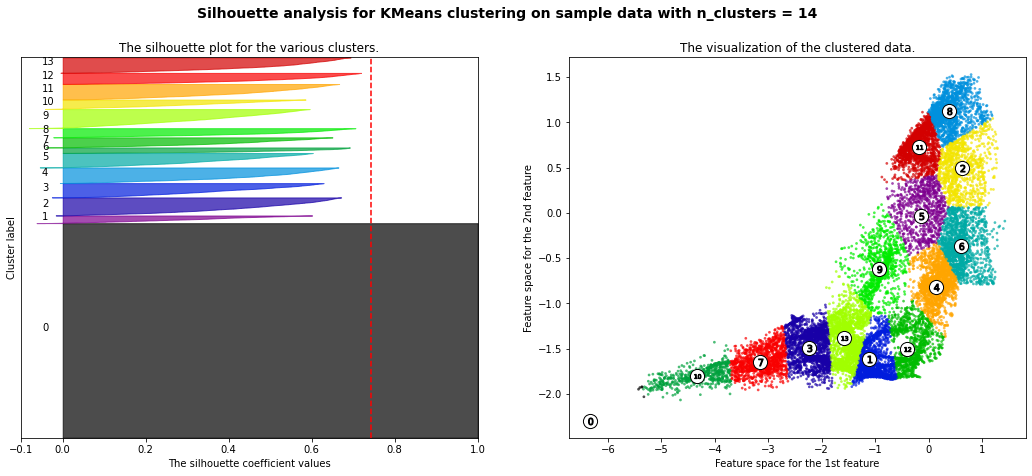

In [14]:
January = data[1]
distortions = []
K = range(6,15)

X = January[0]['arr']

for k in K:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    kmeans = KMeans(n_clusters=k)
    
    cluster_labels = kmeans.fit_predict(X)

    cl_4_elbow = kmeans.fit(X)
    distortions.append(cl_4_elbow.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')    

### Checking Elbow method

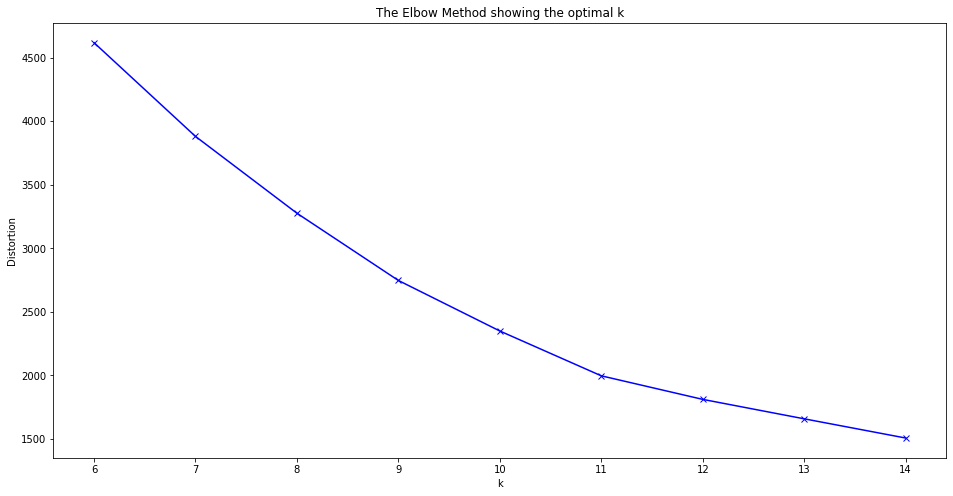

In [15]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Climate clustering for January 1951

According to the silhouette avg results, we will work with 13 clusters for our study
If we don't take in account the oceanic cluster, we have 12 clusters which is coherent with Zscheischler et al. 2012 "Climate Classifications: the Value of Unsupervised Clustering" 

In [16]:
kmeans = KMeans(n_clusters=13)
cluster_labels = kmeans.fit_predict(X)

In [17]:
rlon = len(tas['rlon'])
rlat = len(tas['rlat'])
Z = np.reshape(cluster_labels, (rlat, rlon))

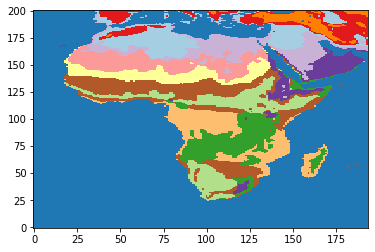

In [18]:
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# Conclusion

This is very short work sample of how to use unsupervised learning applied to Climate. I have several ideas to tackle the problematic for climate change. Don't hesitate if you have any questions related to this document.